## Créditos

O conteúdo deste notebook usa material do tutorial [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models).

## Convolução 1D

Esta parte ilustra exemplos de uso da operação de convolução 1D.

O código abaixo usa a função `np.convolve`. Veja detalhes sobre essa função no link a seguir: [Understanding NumPy's Convolve](https://stackoverflow.com/questions/20036663/understanding-numpys-convolve).

In [ ]:
import numpy as np

input_data = [41., 5., 1., 11., 31., 17., 40.]
kernel = [.5, 1., .3]
C = np.convolve(input_data, kernel)
print(C)

[20.5 43.5 17.8  8.  26.8 42.8 46.3 45.1 12. ]


In [ ]:
0 * .3 + 0 * 1. + 41 * .5

20.5

In [ ]:
import torch
from torch import nn

input_data = torch.tensor([[[41., 5., 1., 11., 31., 17., 40.]]])  
print(input_data)
print(input_data.shape)

conv_layer = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding=2) 

arr = np.array([[[.3, 1., .5]]])
kernel = torch.tensor(arr, dtype = torch.float32)
conv_layer.weight.data = kernel
conv_layer.bias.data = torch.tensor([0])

out = conv_layer(input_data)
print(out.size())
print(out)
print(conv_layer)

tensor([[[41.,  5.,  1., 11., 31., 17., 40.]]])
torch.Size([1, 1, 7])
torch.Size([1, 1, 9])
tensor([[[20.5000, 43.5000, 17.8000,  8.0000, 26.8000, 42.8000, 46.3000,
          45.1000, 12.0000]]], grad_fn=<ConvolutionBackward0>)
Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,))


In [ ]:
import torch
from torch import nn

a = torch.randn(32, 100, 1)  
print(a.shape)
m = nn.Conv1d(100, 100, 1) 
out = m(a)
print(out.size())
print(m)

torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
Conv1d(100, 100, kernel_size=(1,), stride=(1,))


# Demo: previsão de séries temporais

In [ ]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os

Vamos usar nessa demonstração o conjunto de dados [Jena Climate](https://www.kaggle.com/datasets/mnassrib/jena-climate), mantido pelo [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/wetter/). O conjunto de dados consiste de 14 variáveis, como temperatura, pressão, umidade, etc. Essas observações são registradas uma vez a cada 10 minutos. A séria histórica de observações disponivel abrange os anos de 2009 até 2016. Mais detalhes sobre as variáveis componentes deste conjunto de dados podem ser encontradas [aqui](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).

> Vamos construir um modelo de previsão para a variável **temperatura**.

Repare que a variável temperatura é de domínio contínuo. Portanto, estamos diante de uma tarefa de regressão. Para resolver essa tarefa de previsão, vamos construir um modelo **auto-regressivo**.

> Um modelo auto-regressivo é aquele em que observações prévias de uma variável são usadas para prever o valor de observações futuras da mesma variável. Modelos auto-regressivos são normalmente usados no contexto de previsão de séries temporais.

Para construir (ajustar) um modelo auto-regressivo, devem ser definidas duas quantidades:

- $q_{in}$: quantidade de observações prévias usada na predição;
- $q_{out}$: quantidade de observações futuras cujos valores devem ser previstos.

As definições das quantidades acima dependem de restrições associadas ao domínio do problema. Nesse estudo de caso, vamos considerar as quantidades definidas a seguir.

- $q_{in}=3$: as três últimas observações (horárias) de valores da temperatura serão usadas para realizar a predição.
- $q_{out}=1$: o modelo deve produzir uma previsão do valor de temperatura para a hora seguinte.

## Leitura do conjunto de dados

Vamos inicialmente baixar o arquivo com o conjunto de dados.

In [ ]:
zip_file_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Em seguida, vamos carregar esse arquivo (em formato CSV) para um objeto [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [ ]:
df = pd.read_csv('jena_climate_2009_2016.csv')

## Visualização/exploração dos dados

Podemos inspecionar algumas propriedades do conjunto de dados. Veja abaixo.

In [ ]:
df.shape

(420551, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [ ]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [ ]:
df['Date Time'].min(), df['Date Time'].max()

('01.01.2009 00:10:00', '31.12.2016 23:50:00')

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Podemos, também para fins de análise exploratória, visualizar as séries temporais componentes desse conjunto de dados.

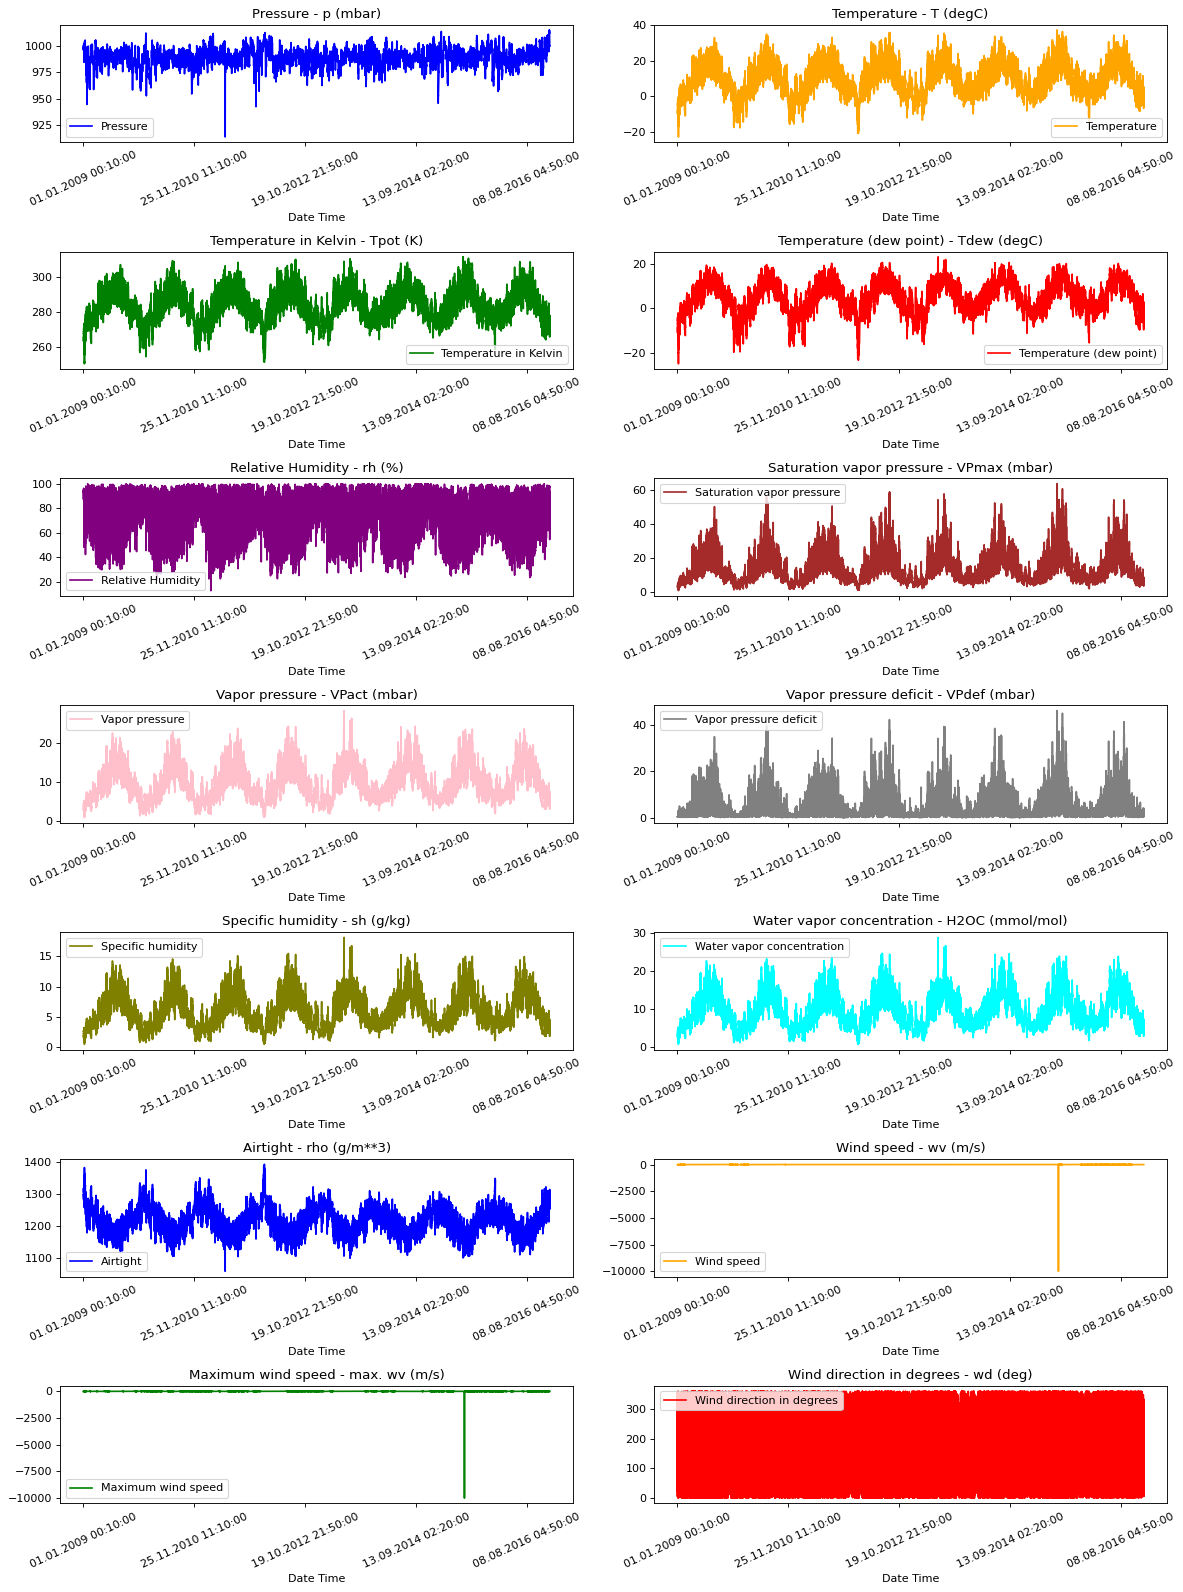

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Preparação (transformação, pré-processamento) dos dados

Por simplificidade, nessa demonstração iremos considerar **predições/observações por hora**. Sendo assim, vamos realizar uma subamostragem dos dados originais para converter a frequência de observações de 10 min para 1 hora.

In [ ]:
print(df.shape)

# slice [start:stop:step], starting from index 5, take every 6th record.
df = df[5::6]

print(df.shape)

(420551, 15)
(70091, 15)


Podemos visualizar novamente os dados e perceber que não ocorreu nenhuma mudança drástica nas distribuições dos valores por conta da subamostragem realizada.

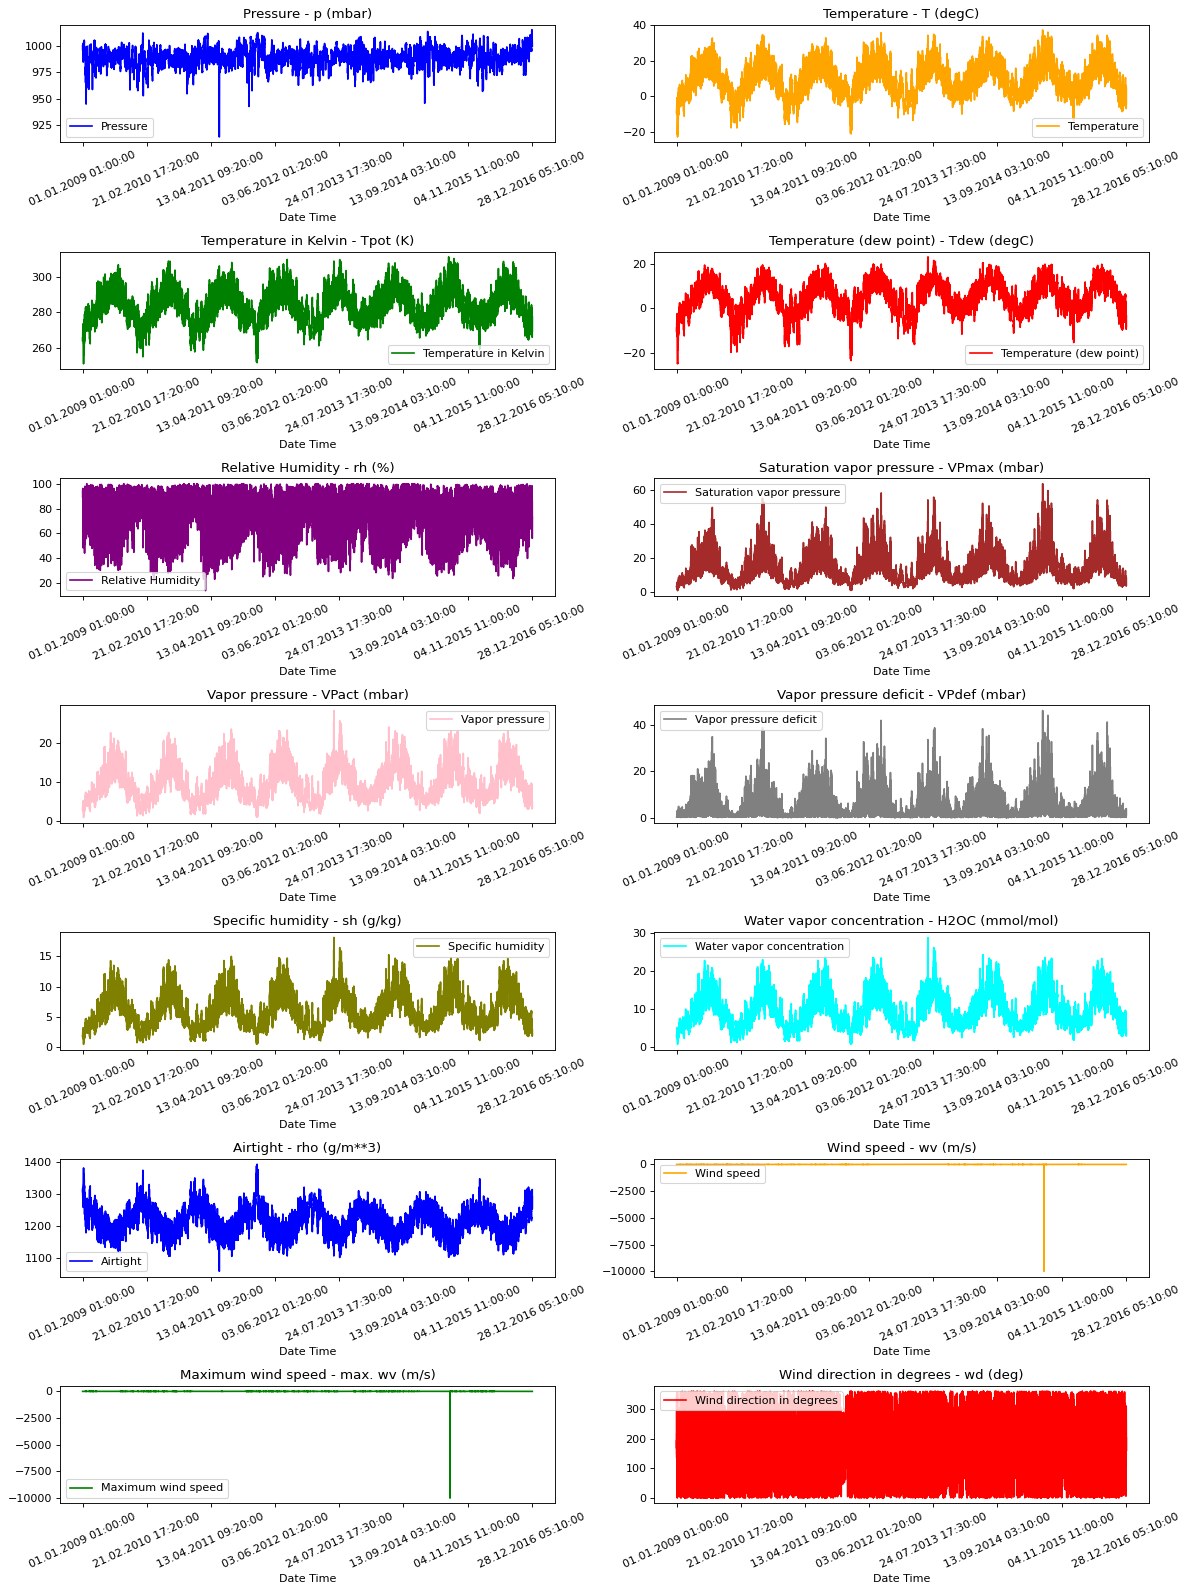

In [ ]:
show_raw_visualization(df)

Esse conjunto de dados possui uma variávei denominada `Date Time` que corresponde à marcação de tempo relativa a cada observação. Em uma aplicação real, esse tipo de variável pode ser usado como preditor, após algumas ações de pré-processamento (e.g., tratamento de **variáveis cíclicas**). Por simplicidade, nessa demonstração, não vamos usar essa variável como preditor.

In [ ]:
date_time = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

Nessa demonstração, vamos construir um modelo de previsão considerando que a variável alvo seja **temperatura** (medida em graus Celsius). A célula de código abaixo exibe um sumário estatístico dessa variável.

In [ ]:
df_multi = df[['T (degC)']]
df_multi.describe()

,T (degC)
count,70091.000000
mean,9.450482
std,8.423384
min,-22.760000
25%,3.350000
50%,9.410000
75%,15.480000
max,37.280000


O histograma dessa variável também parece indicar que não há valores anômalos e que ela segue aproximadamente uma distribuição normal.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a28107910>]],
      dtype=object)

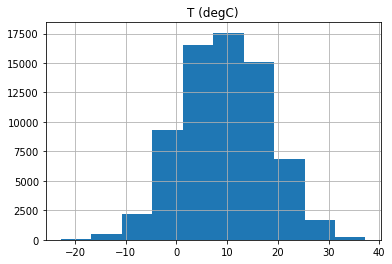

In [ ]:
df_multi.hist()

Vamos agora separar os exemplos originalmente disponíveis em três conjuntos disjuntos:

- **conjunto de treino**: usado para ajustar os parâmetros do modelo de previsão
- **conjunto de validação**: usado para monitorar o processo de treinamento. Também usado para sintonizar os hiperparâmetros do modelo (não estamos fazendo isso nessa demonstração).
- **conjunto de teste**: após o modelo ter sido ajustado, esse conjunto é usado para obter uma estimativa realista do seu desempenho preditivo. 

Em uma aplicação real, o ideal seria utilizar integralmente todos os exemplos disponíveis. Entretanto, para essa demonstração, iremos usar 1200 exemplos para treinar o modelo, 500 exemplos para validação,  e 591 exemplos para teste.

In [ ]:
len(df_multi)

70091

In [ ]:
df_multi.shape

(70091, 1)

In [ ]:
train_set = df_multi[:1200]
valid_set = df_multi[69000:69500]
test_set = df_multi[69500:]
print('Proporção de exemplos para treino: {:.4f}%'.format(len(train_set)/len(df_multi)))
print('Proporção de exemplos para validação: {:.4f}%'.format(len(valid_set)/len(df_multi)))
print('Proporção de exemplos para teste: {:.4f}%'.format(len(valid_set)/len(df_multi)))

Proporção de exemplos para treino: 0.0171%
Proporção de exemplos para validação: 0.0071%
Proporção de exemplos para teste: 0.0071%


In [ ]:
print('Treino: {:d}'.format(train_set.shape[0]))
print('Validação: {:d}'.format(valid_set.shape[0]))
print('Teste: {:d}'.format(test_set.shape[0]))

Treino: 1200
Validação: 500
Teste: 591


### Janelamento (*data windowing*)

Agora devemos processar os conjuntos de dados para formar os exemplos de treinamento. Aqui, vamos enquadrar o problema de previsão em séries temporais como um problema de *aprendizado supervisionado* para construir um modelo auto-regressivo. Para isso, vamos usar a técnica de [janelas deslizantes](https://datascience.stackexchange.com/questions/29173/time-series-forecasting-sliding-window-method) para construir os exemplos. 

A função `window_generator` definida abaixo implementa uma variante da técnica de janelas deslizantes. Essa função recebe dois argumentos:

- `sequence`: a série temporal a ser processada para obtenção dos exemplos de treinamento;
- `n_steps`: a quantidade de observações prévias a serem usadas como preditores.

In [ ]:
def window_generator(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

Para um melhor entendimento da função acima, considere a série temporal fictícia a seguir:
$$
10,20,30,40,50,60,70,80,90
$$

Suponha que, após uma análise criteriosa, decidimos utilizar os valores de temperaturas observados nas **três** últimas horas para prever a temperatura na hora seguinte. Para isso, podemos chamar a função `window_generator` com o valor do argumento `n_steps` igual a 3. Ao fazermos isso, a função retorna duas matrizes. A primeira é a denominada **matriz de dados** e contém os valores usados como preditores. A segunda é conhecida no aprendizado supervisionado como **vetor de resposta** é contém o sinal de aprendizado (i.e., o valor correto que o modelo de previsão deveria produzir).

In [ ]:
n_steps = 3
seq = np.array([10,20,30,40,50,60,70,80,90])
seq_train_x, seq_train_y = window_generator(seq, n_steps)

df_toy = pd.DataFrame(seq_train_x)
df_toy.columns =['t_3', 't_2', 't_1']
df_toy['target'] = seq_train_y.tolist()

df_toy.head()

,t_3,t_2,t_1,target
0,10,20,30,40
1,20,30,40,50
2,30,40,50,60
3,40,50,60,70
4,50,60,70,80


Repare que a função `window_generator` implementa apenas uma variante particular da técnica de janela deslizantes. Em particular essa função gera o conjunto de dados de treinamento de acordo com a abordagem [single step prediction](https://machinelearningmastery.com/multi-step-time-series-forecasting/), o que corresponde a definir $q_{out}=1$.

### Divisão: treino, validação, teste

Vamos agora aplicar a técnica de janelas deslizantes aos dados de temperatura contidos em nosso conjunto de dados. Vamos considerar que a quantidade de observações prévias usadas para realizar a previsão é igual a 3 (i.e., $q_{in}=3)$.

In [ ]:
n_steps = 3 # q_in
train_x, train_y = window_generator(train_set.values, n_steps)
valid_x, valid_y = window_generator(valid_set.values, n_steps)
test_x, test_y = window_generator(test_set.values, n_steps)

In [ ]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

(1197, 3, 1)
(497, 3, 1)
(588, 3, 1)


In [ ]:
train_x

array([[[-8.05],
        [-8.88],
        [-8.81]],

       [[-8.88],
        [-8.81],
        [-9.05]],

       [[-8.81],
        [-9.05],
        [-9.63]],

       ...,

       [[-1.49],
        [-1.57],
        [-1.3 ]],

       [[-1.57],
        [-1.3 ],
        [-1.28]],

       [[-1.3 ],
        [-1.28],
        [-1.93]]])

Agora transformamos as variáveis em tensores PyTorch para uso no ajuste e validação do modelo. Veja o bloco de código abaixo.

In [ ]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

valid_x = torch.from_numpy(valid_x)
valid_y = torch.from_numpy(valid_y)

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

### Reposicionamento de dimensões

O PyTorch espera que cada tensor usado no treinamento tenha a forma `[batch, channels_in, time]`. Em particular, a dimensão das features `channels_in` deve ser a central nos tensores. Sendo assim, o código abaixo usa a função `permute` para pivotear (reposicionar) a ordem das dimensões dentro de cada tensor: as posições das dimensões originais 0, 1 e 2 são trocadas para as posições 0, 2 e 1.

In [ ]:
train_x = torch.permute(train_x, (0, 2, 1))
valid_x = torch.permute(valid_x, (0, 2, 1))
test_x = torch.permute(test_x, (0, 2, 1))

print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

torch.Size([1197, 1, 3])
torch.Size([497, 1, 3])
torch.Size([588, 1, 3])


Vamos agora criar os objetos `TensorDataset` e `Dataloader` para os conjuntos de treino, validação e teste.

In [ ]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(train_x, train_y)
valid_ds = TensorDataset(valid_x, valid_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

O código acima não faz nenhuma transformação especial. Em vez disso, ela formata os dados para serem usados pelo PyTorch durante o processo de treinamento do modelo. 

Como exemplo, considere a célula de código abaixo, que imprime os cinco primeiros exemplos contidos no conjunto de dados de treinamento encapsulado pelo objeto `TensorDataset`.

In [ ]:
train_ds = TensorDataset(train_x, train_y)
train_ds[0:5]

(tensor([[[-8.0500, -8.8800, -8.8100]],
 
         [[-8.8800, -8.8100, -9.0500]],
 
         [[-8.8100, -9.0500, -9.6300]],
 
         [[-9.0500, -9.6300, -9.6700]],
 
         [[-9.6300, -9.6700, -9.1700]]], dtype=torch.float64),
 tensor([[-9.0500],
         [-9.6300],
         [-9.6700],
         [-9.1700],
         [-8.1000]], dtype=torch.float64))

O hiperparâmetro `BATCH_SIZE` (usado para configurar o objeto `DataLoader`) define a quantidade de exemplos a ser usada em cada rodada de ajuste dos parâmetros do modelo.

Para fins de inspeção, o bloco de código a seguir imprime os exemplos componentes do primeiro lote de de treinamento.

In [ ]:
for xb, yb in train_loader:
    print(xb)
    print(yb)
    break

tensor([[[-8.0500, -8.8800, -8.8100]],

        [[-8.8800, -8.8100, -9.0500]],

        [[-8.8100, -9.0500, -9.6300]],

        [[-9.0500, -9.6300, -9.6700]],

        [[-9.6300, -9.6700, -9.1700]],

        [[-9.6700, -9.1700, -8.1000]],

        [[-9.1700, -8.1000, -7.6600]],

        [[-8.1000, -7.6600, -7.0400]],

        [[-7.6600, -7.0400, -7.4100]],

        [[-7.0400, -7.4100, -6.8700]],

        [[-7.4100, -6.8700, -5.8900]],

        [[-6.8700, -5.8900, -5.9400]],

        [[-5.8900, -5.9400, -5.6900]],

        [[-5.9400, -5.6900, -5.4000]],

        [[-5.6900, -5.4000, -5.3700]],

        [[-5.4000, -5.3700, -5.2500]],

        [[-5.3700, -5.2500, -5.1100]],

        [[-5.2500, -5.1100, -4.9000]],

        [[-5.1100, -4.9000, -4.8000]],

        [[-4.9000, -4.8000, -4.5000]],

        [[-4.8000, -4.5000, -4.4700]],

        [[-4.5000, -4.4700, -4.5400]],

        [[-4.4700, -4.5400, -4.4400]],

        [[-4.5400, -4.4400, -4.2900]],

        [[-4.4400, -4.2900, -4.4500]],



## Definição da rede neural

Agora vamos definir a classe que corresponde à rede neural a ser treinada. No PyTorch, é uma boa prática implementar essa classe como uma subclasse de [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

Repare que a classe [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) é usada na definição da arquitetura de rede neural acima. Em particular o parâmetro `in_channels` usado na instanciação desta camada corresponde à quantidade de features observadas a cada passo de tempo. Visto que a cada passo de tempo consideramos apenas um valor de temperatura, definimos `in_channels = 1`.

O bloco de código a seguir cria o modelo e move-o para o espaço de memória da GPU (se uma estiver disponível).

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=1).to(device)

Podemos obter uma visão geral da arquitetura da rede neural montada apenas imprimindo a variável `model`.

In [ ]:
print(model)

Net(
  (conv1d): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


Tente refletir sobre a razão de a primeira camada completamente conectada (fc1) ter dimensão de entrada igual a 128.

Vamos agora definir a função perda a ser utilizada durante o treinamento. Vamos usar a função MSE.

In [ ]:
criterion = nn.MSELoss()

Apenas para fins de inspeção, o bloco de código a seguir imprime as dimensões do tensor correspondente ao primeiro lote de treinamento.

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 1, 3])
torch.Size([32, 1])


Também para fins de inspeção e comparação posterior, vamos computar o erro médio cometido pelo modelo (ainda não treinado!) sobre o conjunto de teste.

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

18.865035019422834


## Treinamento do modelo (PyTorch)

Nesse ponto, está tudo pronto para iniciar o treinamento do modelo. A função `fit` definida abaixo realiza esse treinamento.

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

Uma estratégia simples que pode ser adotada durante o treinamento é definir uma quantidade fixa de épocas de treinamento.

In [ ]:
n_epochs = 300
model = model.float()
model, train_loss, valid_loss = fit(n_epochs, 1e-5, model, train_loader, valid_loader, opt_func=torch.optim.Adam)

[  0/300] train_loss: 28.62509 valid_loss: 36.33004
[  1/300] train_loss: 28.18881 valid_loss: 35.59782
[  2/300] train_loss: 27.74021 valid_loss: 34.86817
[  3/300] train_loss: 27.27834 valid_loss: 34.14510
[  4/300] train_loss: 26.81467 valid_loss: 33.43220
[  5/300] train_loss: 26.35430 valid_loss: 32.73225
[  6/300] train_loss: 25.89899 valid_loss: 32.04698
[  7/300] train_loss: 25.45019 valid_loss: 31.37450
[  8/300] train_loss: 25.00819 valid_loss: 30.71026
[  9/300] train_loss: 24.57239 valid_loss: 30.05021
[ 10/300] train_loss: 24.14278 valid_loss: 29.39248
[ 11/300] train_loss: 23.71797 valid_loss: 28.73054
[ 12/300] train_loss: 23.29453 valid_loss: 28.06305
[ 13/300] train_loss: 22.87425 valid_loss: 27.40204
[ 14/300] train_loss: 22.45859 valid_loss: 26.75516
[ 15/300] train_loss: 22.04559 valid_loss: 26.11722
[ 16/300] train_loss: 21.62034 valid_loss: 25.48163
[ 17/300] train_loss: 21.16865 valid_loss: 24.85274
[ 18/300] train_loss: 20.70196 valid_loss: 24.22315
[ 19/300] tr

Porque os erros de treino e de validação foram registrados durante o treinamento, podemos desenhar um gráfico para analisar visualmente a evolução desses valores. Isso é feito na célula de código abaixo.

O gráfico gerado apresenta duas curvas, uma para o erro medido no conjunto de treinamento e outra para o erro medido no conjunto de validação. Essas chamadas **curvas de aprendizado** (*learning curves*) são muito úteis para realizar disgnósticos durante o treinamento. 


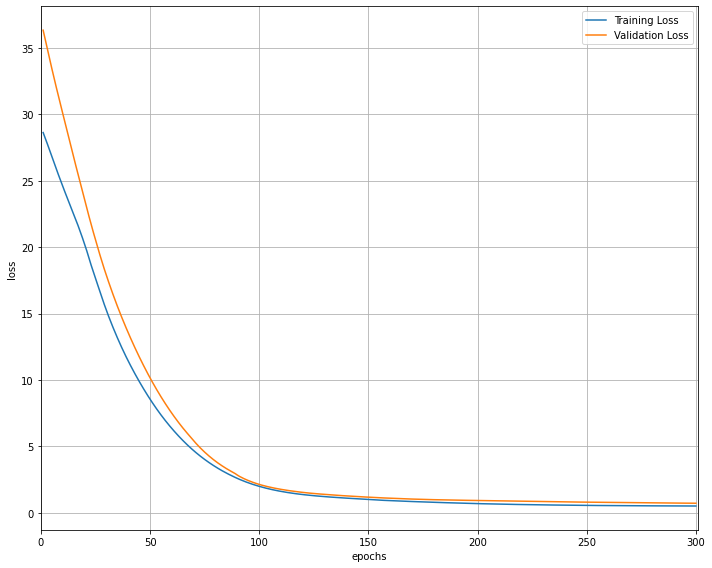

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

A análise do gráfico acima parece indicar que o treinamento aconteceu de forma satisfatória. Para confirmar isso, devemos usar o modelo recém-ajustado para predizer os valores de temperatura sobre o conjunto de dados de teste.

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.4833474429814439


O resultado produzido pelo bloco de código acima é o erro médio (computado usando a métrica MSE) do modelo sobre os exemplos de teste. Compare esse valor (obtido após o treinamento) com o que computamos antes do treinamento. O que você percebe de diferente?

## Predição (inferência)

Uma vez que o modelo está treinado (ajustado), podemos usá-lo para realizar inferências. No código abaixo, apenas a título de exemplo, os 10 primeiros exemplos do conjunto de teste são passados ao modelo. 

In [ ]:
# TODO

# Demo: múltiplas features

Na seção anterior, vimos como treinar uma rede neural convolucional unidimensional sobre uma série temporal univariada, i.e., consideramos que uma única feature era observada a cada passo de tempo. Nesta seção, vamos desenvolver um modelo de rede neural convolucional unidimensional mais genérico, que utiliza todas as dezenove as features do conjunto de dados [Jena Climate](https://www.kaggle.com/datasets/mnassrib/jena-climate).

In [2]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os

In [ ]:
zip_file_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
df = pd.read_csv('jena_climate_2009_2016.csv')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Minha versão

In [12]:
df = pd.read_csv('sao_cristovao.csv')
del df['Unnamed: 0']
df = df.fillna(0)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731548 entries, 0 to 731547
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Dia          731548 non-null  object 
 1   Hora         731548 non-null  object 
 2   HBV          731548 non-null  object 
 3   Chuva        731548 non-null  float64
 4   DirVento     731548 non-null  float64
 5   VelVento     731548 non-null  float64
 6   Temperatura  731548 non-null  float64
 7   Pressao      731548 non-null  float64
 8   Umidade      731548 non-null  float64
 9   estacao      731548 non-null  object 
dtypes: float64(6), object(4)
memory usage: 55.8+ MB


In [ ]:
import pandas as pd

df_og = pd.read_csv("FORTE-DE-COPACABANA_1997_2022.csv")
df_og.shape

(123072, 28)

In [ ]:
semchuva = df_og[df_og.CHUVA == 0].count()
porcentagem = semchuva['CHUVA'] / df_og['CHUVA'].count()
porcentagem * 100

91.20512862715408

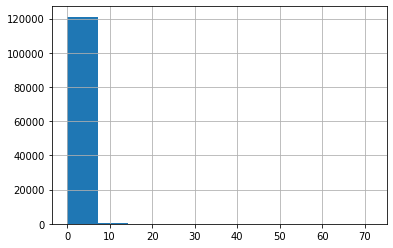

In [ ]:
df_og.CHUVA.hist()

In [ ]:
df = df_og.dropna(axis='rows')
df.DT_MEDICAO = pd.to_datetime(df.DT_MEDICAO)
df = df[(df.DT_MEDICAO.dt.month >= 1) & (df.DT_MEDICAO.dt.month <= 3)]
df = df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(25232, 21)

In [ ]:
semchuva = df[df.CHUVA == 0].count()
porcentagem = semchuva['CHUVA'] / df['CHUVA'].count()
porcentagem * 100

91.31261889663918

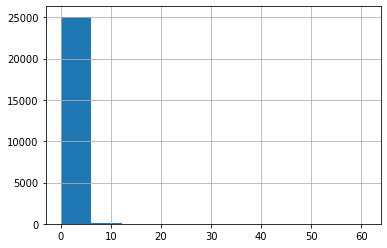

In [ ]:
df.CHUVA.hist()

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_1997_2022.csv')
del df['Unnamed: 0']
df = df.fillna(method='ffill')
df.info()

## Preparação dos dados

### Transformação/criação de variáveis (*feature engineering*)

#### Velocidade do vento

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

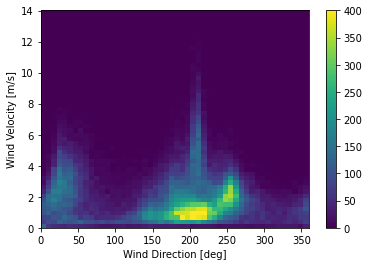

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

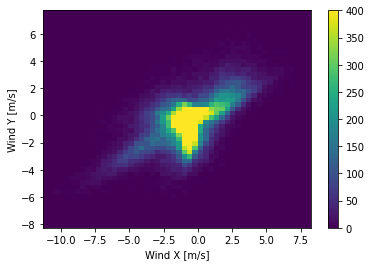

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

**Graficos de Vento São Cristóvão**

Text(0, 0.5, 'Wind Velocity [m/s]')

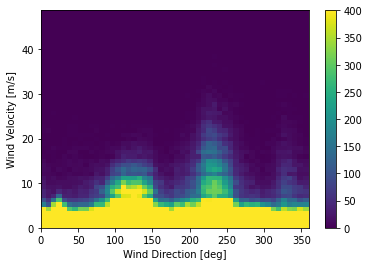

In [13]:
plt.hist2d(df['DirVento'].fillna(0), df['VelVento'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-34.110842134528475, 43.55705582024557, -43.670821831503254, 40.8937707318964)

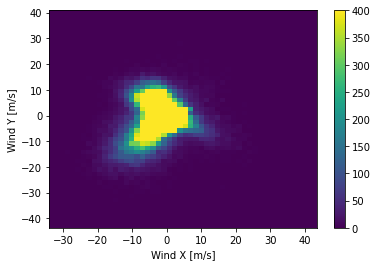

In [14]:
wv = df['VelVento']
wd_rad = df['DirVento']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

**Grafico Forte Copacabana**

Text(0, 0.5, 'Wind Velocity [m/s]')

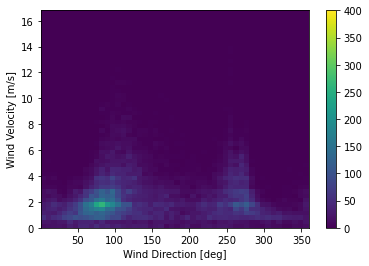

In [ ]:
plt.hist2d(df['VEN_DIR'], df['VEN_VEL'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-11.098309416235942,
 6.7989643270634605,
 -16.67477534757421,
 12.408577687953821)

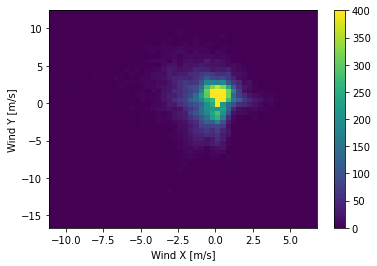

In [ ]:
wv = df['VEN_VEL']
wd_rad = df['VEN_DIR']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Variáveis cíclicas

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

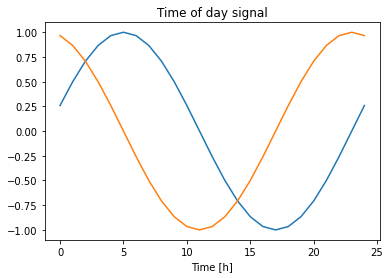

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

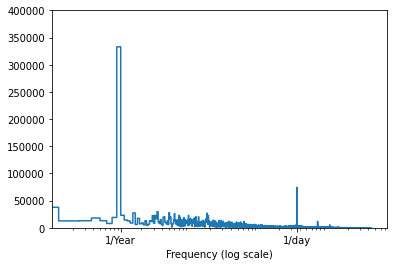

In [ ]:
fft = np.fft.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Divisão: treino, validação, teste

Agora dividimos os dados usando a seguinte proporção:

- 70% para treinamento
- 20% para validação
- 10% para teste

Observe que os dados não estão sendo embaralhados aleatoriamente antes da divisão. Isso por dois motivos:

- Garante que ainda é possível separar os dados em janelas de amostras consecutivas.
- Garante que os resultados da validação/teste sejam mais realistas, sendo avaliados nos dados coletados após o treinamento do modelo.

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(512083, 12)


Conjunto de Validação
(146310, 12)


Conjunto de Teste
(73155, 12)


### Normalização dos dados

É importante padronizar as faixas de valores das features antes de treinar uma rede neural. A *normalização* é uma maneira comum de fazer essa escala: subtrair a média e dividir pelo desvio padrão de cada feature.

A média e o desvio padrão só devem ser calculados usando os dados de treinamento para que os modelos não tenham acesso aos valores nos conjuntos de validação e teste.

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

COR

In [7]:
train_df = train_df.drop(columns=['Dia','Hora','HBV','estacao'])

val_df = val_df.drop(columns=['Dia','Hora','HBV','estacao'])

test_df = test_df.drop(columns=['Dia','Hora','HBV','estacao'])

INMET

In [ ]:
print('train_mean')
print(train_mean)
print('\n')

print('train_std')
print(train_std)
print('\n')
                                                                    
train_df = train_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('train_df')
print(train_df)
print('\n')

val_df = val_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('val_df')
print(val_df)
print('\n')

test_df = test_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('test_df')
print(test_df)
print('\n')

train_mean
Unnamed: 0      4228.831868
PRE_INS         1011.270114
TEM_SEN           22.939668
VL_LATITUDE      -22.988333
PRE_MAX         1011.505450
RAD_GLO          754.073429
PTO_INS           19.305717
TEM_MIN           23.114453
VL_LONGITUDE     -43.190556
UMD_MIN           75.095937
PTO_MAX           19.820632
VEN_DIR          156.969145
CHUVA              0.121730
PRE_MIN         1011.033169
UMD_MAX           80.025241
VEN_VEL            2.685001
PTO_MIN           18.804672
TEM_MAX           24.200062
TEN_BAT           12.948671
VEN_RAJ            5.660582
TEM_CPU           25.597337
TEM_INS           23.639601
UMD_INS           77.638299
HR_MEDICAO      1153.877814
Wx                -0.292069
Wy                 0.378985
dtype: float64


train_std
Unnamed: 0      2.561133e+03
PRE_INS         4.760966e+00
TEM_SEN         4.617957e+00
VL_LATITUDE     7.105477e-15
PRE_MAX         4.745626e+00
RAD_GLO         1.102976e+03
PTO_INS         2.836644e+00
TEM_MIN         2.957273e+00
VL

Agora, vamos dar uma olhada na distribuição das features. No gráfico que apresenta várias [tramas de violino](https://en.wikipedia.org/wiki/Violin_plot) produzido pelo bloco de código abaixo, podemos ver que algumas features têm caudas longas, mas não há erros óbvios como o valor  -9999 encontrado na velocidade do vento.

In [ ]:
df_std = (df - train_mean) / train_std

df_std['PRE_INS'].describe()

count    123072.000000
mean          0.000822
std           0.993289
min          -3.471505
25%          -0.703689
50%          -0.079369
75%           0.669814
max           3.624926
Name: PRE_INS, dtype: float64

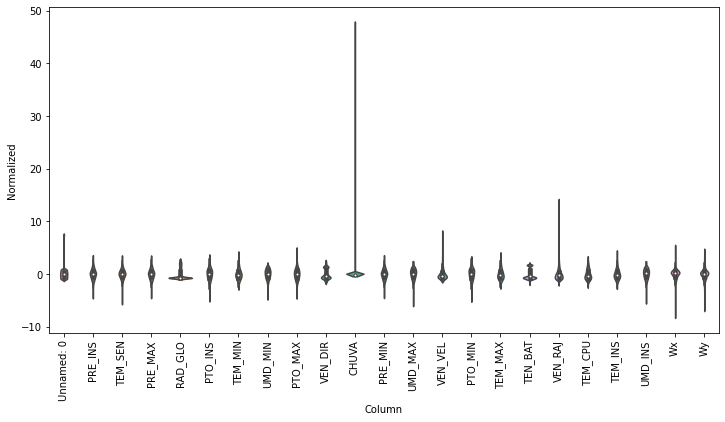

In [ ]:
import seaborn as sns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std['Column'], y=df_std['Normalized'].astype('float32'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

COR

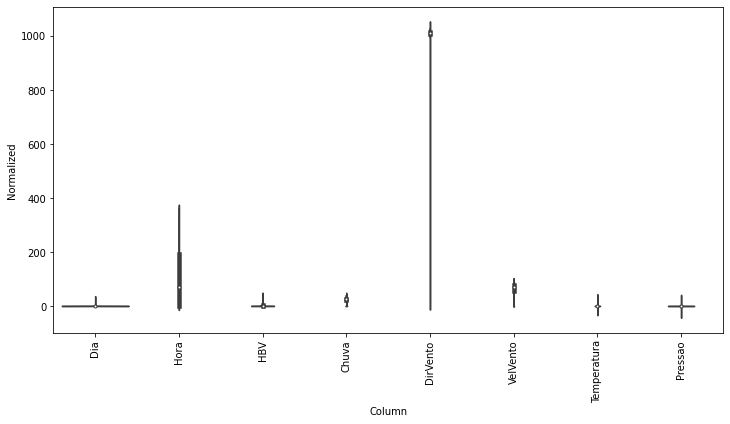

In [11]:
import seaborn as sns
df_std = (df - train_mean) / train_std
df2 = df.drop(columns=['Dia','Hora','HBV','estacao'])
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

INMET

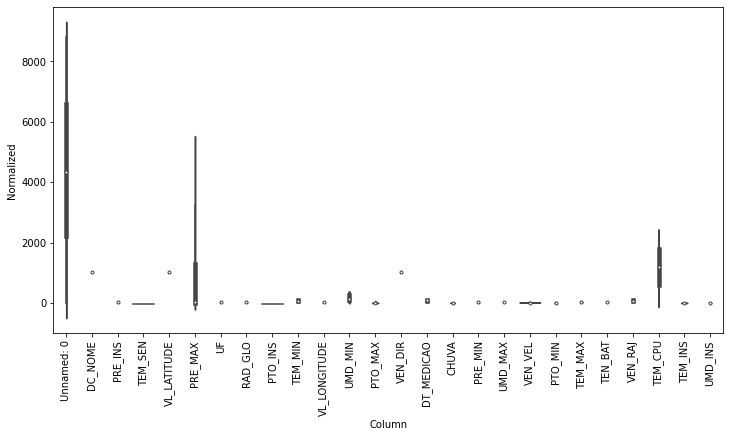

In [ ]:
import seaborn as sns
#f_std = (df - train_mean) / train_std
df2 = df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO'])
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Janelamento (*data windowing*)


In [ ]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17662 entries, 0 to 88630
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  17662 non-null  float64
 1   PRE_INS     17662 non-null  float64
 2   TEM_SEN     17662 non-null  float64
 3   PRE_MAX     17662 non-null  float64
 4   RAD_GLO     17662 non-null  float64
 5   PTO_INS     17662 non-null  float64
 6   TEM_MIN     17662 non-null  float64
 7   UMD_MIN     17662 non-null  float64
 8   PTO_MAX     17662 non-null  float64
 9   VEN_DIR     17662 non-null  float64
 10  CHUVA       17662 non-null  float64
 11  PRE_MIN     17662 non-null  float64
 12  UMD_MAX     17662 non-null  float64
 13  VEN_VEL     17662 non-null  float64
 14  PTO_MIN     17662 non-null  float64
 15  TEM_MAX     17662 non-null  float64
 16  TEN_BAT     17662 non-null  float64
 17  VEN_RAJ     17662 non-null  float64
 18  TEM_CPU     17662 non-null  float64
 19  TEM_INS     17662 non-nul

In [ ]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de A')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)


Conjunto de Treinamento
(17662, 23)
Conjunto de A
(5046, 23)
Conjunto de Teste
(2524, 23)


In [ ]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 3
IDX_TARGET = 10 # index of column 'T (degC)' is 1

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(17659, 3, 23)
(17659, 1)


Janelamento do Conjunto de Validação
(5043, 3, 23)
(5043, 1)


Janelamento do Conjunto de Teste
(2521, 3, 23)
(2521, 1)




O PyTorch espera que cada tensor usado no treinamento tenha a forma `[batch, channels_in, time]`. Em particular, a dimensão das features `channels_in` deve ser a central nos tensores. Sendo assim, o código abaixo usa a função `permute` para pivotear (reposicionar) a ordem das dimensões dentro de cada tensor: as posições das dimensões originais 0, 1 e 2 são trocadas para as posições 0, 2 e 1.

In [ ]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([17659, 23, 3])
torch.Size([17659, 1])


torch.Size([5043, 23, 3])
torch.Size([5043, 1])


torch.Size([2521, 23, 3])
torch.Size([2521, 1])




In [ ]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
train_ds

### Treinamento do modelo

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=23).to(device)

In [ ]:
print(model)

Net(
  (conv1d): Conv1d(23, 64, kernel_size=(2,), stride=(1,))
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
criterion = nn.MSELoss()

Apenas para fins de inspeção, o bloco de código a seguir imprime as dimensões do tensor correspondente ao primeiro lote de treinamento.

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 23, 3])
torch.Size([32, 1])


Também para fins de inspeção e comparação posterior, vamos computar o erro médio cometido pelo modelo (ainda não treinado!) sobre o conjunto de teste.

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.7055294204862859


In [ ]:
n_epochs = 500
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[  0/500] train_loss: 1.02762 valid_loss: 2.64822
[  1/500] train_loss: 1.01445 valid_loss: 2.62545
[  2/500] train_loss: 1.00406 valid_loss: 2.60668
[  3/500] train_loss: 0.99534 valid_loss: 2.59037
[  4/500] train_loss: 0.98777 valid_loss: 2.57582
[  5/500] train_loss: 0.98103 valid_loss: 2.56260
[  6/500] train_loss: 0.97496 valid_loss: 2.55042
[  7/500] train_loss: 0.96944 valid_loss: 2.53909
[  8/500] train_loss: 0.96436 valid_loss: 2.52829
[  9/500] train_loss: 0.95960 valid_loss: 2.51796
[ 10/500] train_loss: 0.95516 valid_loss: 2.50813
[ 11/500] train_loss: 0.95100 valid_loss: 2.49880
[ 12/500] train_loss: 0.94705 valid_loss: 2.48991
[ 13/500] train_loss: 0.94333 valid_loss: 2.48137
[ 14/500] train_loss: 0.93976 valid_loss: 2.47315
[ 15/500] train_loss: 0.93630 valid_loss: 2.46505
[ 16/500] train_loss: 0.93296 valid_loss: 2.45720
[ 17/500] train_loss: 0.92973 valid_loss: 2.44958
[ 18/500] train_loss: 0.92658 valid_loss: 2.44224
[ 19/500] train_loss: 0.92353 valid_loss: 2.43498


In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.6372237078421101


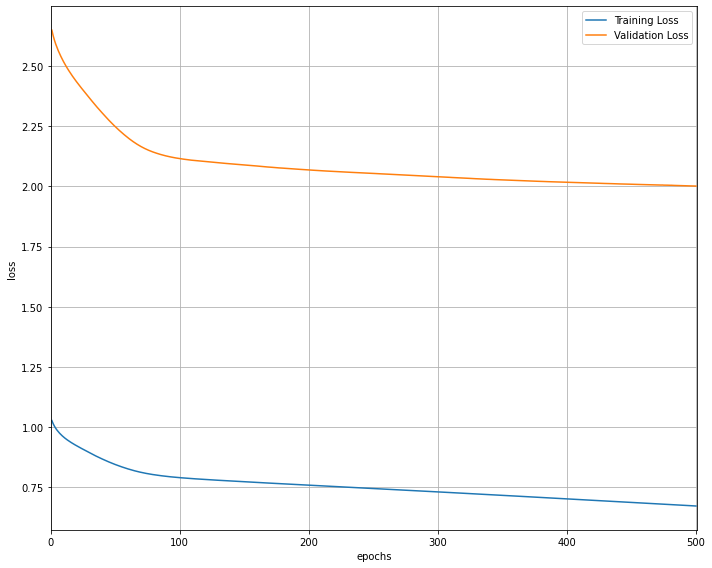

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Referências

- [How to perform a 1D convolution in python ?](https://moonbooks.org/Articles/How-to-perform-a-1D-convolution-in-python-/#references)

- [4 Strategies for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting/)

- [Time Series One Step Ahead vs N-Step Ahead](https://stats.stackexchange.com/questions/342392/time-series-one-step-ahead-vs-n-step-ahead)

- [How to Train Your Neural Net](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29)

- [How to Develop Convolutional Neural Network Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting)

- [What does the "No Free Lunch" theorem mean for machine learning? In what ways do popular ML algorithms overcome the limitations set by this theorem?](https://www.quora.com/What-does-the-No-Free-Lunch-theorem-mean-for-machine-learning-In-what-ways-do-popular-ML-algorithms-overcome-the-limitations-set-by-this-theorem)

- [How to Decompose Time Series Data into Trend and Seasonality](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python)

- [Time series forecasting](www.tensorflow.org/tutorials/structured_data/time_series)

- [Demand forecasting with the Temporal Fusion Transformer](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html#Evaluate-performance)

- [PyTorch Performance Analysis with TensorBoard](https://towardsdatascience.com/pytorch-performance-analysis-with-tensorboard-7c61f91071aa)

- [Introducing PyTorch Forecasting](https://towardsdatascience.com/introducing-pytorch-forecasting-64de99b9ef46)

- [1D convolution for neural networks](https://www.youtube.com/watch?v=XBF9iqt0CnA)

- [1D convolutional neural networks and applications: A survey](https://www.sciencedirect.com/science/article/pii/S0888327020307846)

- [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

- [Learning Spatiotemporal Features with 3D Convolutional Networks](https://arxiv.org/abs/1412.0767)

- [Introduction to Machine Learning with Time Series || Markus Loning](https://youtu.be/wqQKFu41FIw)



# Miscelânea

In [ ]:
import numpy as np
X = np.random.randint(0, 100, (10,3))
X

array([[67, 56, 11],
       [71, 17, 69],
       [94, 50, 39],
       [77, 71,  1],
       [25, 71, 75],
       [25, 63, 39],
       [30, 68, 94],
       [66, 55, 64],
       [15, 11,  8],
       [67, 13, 49]])

In [ ]:
X[2:10:1, 2]

array([39,  1, 75, 39, 94, 64,  8, 49])

In [ ]:
X[np.array([1,2,3,4])]

array([[71, 17, 69],
       [94, 50, 39],
       [77, 71,  1],
       [25, 71, 75]])

In [ ]:
X.shape[1]

3

In [ ]:
I = np.array([[0,1,2,3], [1,2,3,4], [2,3,4,5]])
X[I]

array([[[67, 56, 11],
        [71, 17, 69],
        [94, 50, 39],
        [77, 71,  1]],

       [[71, 17, 69],
        [94, 50, 39],
        [77, 71,  1],
        [25, 71, 75]],

       [[94, 50, 39],
        [77, 71,  1],
        [25, 71, 75],
        [25, 63, 39]]])

In [ ]:
import numpy as np
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
X

array([[67, 56, 11],
       [71, 17, 69],
       [94, 50, 39],
       [77, 71,  1],
       [25, 71, 75],
       [25, 63, 39],
       [30, 68, 94],
       [66, 55, 64],
       [15, 11,  8],
       [67, 13, 49]])

In [ ]:
len(X)

10

In [ ]:
WS = 2
x_train, y_train = apply_windowing(X, 
                                  initial_time_step=0, 
                                  max_time_step=len(X)-WS-1, 
                                  window_size = WS, 
                                  idx_target=2)

In [ ]:
y_train

array([39,  1, 75, 39, 94, 64,  8, 49])

In [ ]:
x_train

array([[[67, 56, 11],
        [71, 17, 69]],

       [[71, 17, 69],
        [94, 50, 39]],

       [[94, 50, 39],
        [77, 71,  1]],

       [[77, 71,  1],
        [25, 71, 75]],

       [[25, 71, 75],
        [25, 63, 39]],

       [[25, 63, 39],
        [30, 68, 94]],

       [[30, 68, 94],
        [66, 55, 64]],

       [[66, 55, 64],
        [15, 11,  8]]])

In [ ]:
X_big = np.array(train_df[:])

In [ ]:
x,y = apply_windowing(X_big, initial_time_index = 0, max_time = 8, window_size = 2)

In [ ]:
x = torch.from_numpy(x)
x = torch.permute(x, (0, 2, 1))
x.shape

torch.Size([9, 19, 2])